In [206]:
import unittest
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from random import randint
from tqdm import tqdm
from scipy.stats import entropy
import math
from collections import Counter
import pandas as pd
import hashlib
import array, random
import math
from classgroup import *
from classgroup_helper import *
import time
import json
from scipy.stats import chisquare
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression

In [2]:
## this code is taken from here: https://github.com/coinstudent2048/bquadform

# Miscellaneous utilities for bquadform.py
#
# Use this code only for prototyping

# integer square root (floor)
# reference: Algorithm 1.7.1 (p.38) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def isqrt(n):
    if not isinstance(n, int):
        raise TypeError("input is not integer")
    if n < 0:
        raise ValueError("input is negative")
    if n == 0:
        return 0
    # [Initialize]
    x = 1 << (n.bit_length() + 2 >> 1)
    while True:
        # [Newtonian step]
        y = (x + n // x) >> 1
        # [Finished?]
        if y >= x:
            return x
        x = y

# # integer square root (ceiling)
# def isqrt_ceil(n):
#     if n == 0:
#         return 0
#     else:
#         return 1 + isqrt(n - 1)

# Euclidean division: always ensures that
# 0 <= r < |b| regardless of sign of divisor
def divmod_euclid(a, b):
    q, r = divmod(a, b)   # divmod uses floor division
    if r < 0:
        q += 1
        r -= b
    return (q, r)

# extended Euclidean algorithm (assumes a >= 0 & b >= 0)
# reference: Algorithm 1.3.6 (p.16) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def ext_euclid(a, b, u=1, v1=0):
    # [Initialize]
    d = a
    # v to be computed in ext_euclid_front()
    if b == 0:
        return (u, d)
    v3 = b
    # [Finished?]
    while v3 != 0:
        # [Euclidean step]
        q, t3 = divmod(d, v3)
        t1 = u - q * v1
        u = v1
        d = v3
        v1 = t1
        v3 = t3
    # [Finished?] cont. moved to ext_euclid_front()
    return (u, d)

# extended partial Euclidean algorithm
# reference: Sub-algorithm PARTEUCL(a, b) (p. 248) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def part_euclid(d, v3, v, v2, L):
    # [Initialize]
    z = 0
    # [Finished?]
    while abs(v3) > L:
        # [Euclidean step]
        q, t3 = divmod_euclid(d, v3)
        t2 = v - q * v2
        v = v2
        d = v3
        v2 = t2
        v3 = t3
        z += 1
    # [Finished?] cont. moved to part_euclid_front()
    return (v, d, v2, v3, z)

# most significant digit of a, and the value of b in same place
# in base M (assumes a >= b, a >= 0, and b >= 0)
def same_msd(a, b, M):
    while a >= M:
        a //= M
        b //= M
    return a, b

# Lehmer extended (assumes a >= b, a >= 0, and b >= 0)
# reference: Algorithm 1.3.7 (p. 17) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def lehmer(a, b, M):
    # [Initialize]
    u = 1
    v1 = 0
    # [Finished?]
    while b >= M:
        a_hat, b_hat = same_msd(a, b, M)
        A = 1
        B = 0
        C = 0
        D = 1
        # [Test quotient]
        while not (b_hat + C == 0 or b_hat + D == 0):
            q = (a_hat + A) // (b_hat + C)
            if q != ((a_hat + B) // (b_hat + D)):
                break
            # [Euclidean step]
            T = A - q * C
            A = C
            C = T
            T = B - q * D
            B = D
            D = T
            T = a_hat - q * b_hat
            a_hat = b_hat
            b_hat = T
        # [Multi-precision step]
        if B == 0:
            q, t = divmod(a, b)
            a = b
            b = t
            t = u - q * v1
            u = v1
            v1 = t
        else:
            t = A * a + B * b
            r = C * a + D * b
            a = t
            b = r
            t = A * u + B * v1
            r = C * u + D * v1
            u = t
            v1 = r
    return a, b, u, v1

# "frontend" for extended Euclidean algorithm
def ext_euclid_front(a, b, use_lehmer=True, M=(1 << 32)):
    # init: the algorithms assume that a >= 0 & b >= 0
    orig_a = a
    orig_b = b
    if orig_a < 0:
        a = -a
    if orig_b < 0:
        b = -b
    # execute algorithms
    if use_lehmer and a < b:
        at = a
        bt = b
        b, a, u, v1 = lehmer(b, a, M)
        u, d = ext_euclid(b, a, u, v1)
        v = u
        u = (d - bt * v) // at   # [Finished?] cont. of Euclid Extended
    elif use_lehmer:
        at = a
        bt = b
        a, b, u, v1 = lehmer(a, b, M)
        u, d = ext_euclid(a, b, u, v1)
        v = (d - at * u) // bt   # [Finished?] cont. of Euclid Extended
    else:
        u, d = ext_euclid(a, b)
        v = (d - a * u) // b   # [Finished?] cont. of Euclid Extended
    # final: check sign of orig a & b
    if orig_a < 0:
        a = -a
        u = -u
    if b < 0:
        b = -b
        v = -v
    return (u, v, d)

# "frontend" for extended partial Euclidean algorithm
def part_euclid_front(d, v3, v, v2, L):   # TODO: use_lehmer=True, M=(1 << 32)
    # execute algorithms
    v, d, v2, v3, z = part_euclid(d, v3, v, v2, L)
    # final: [Finished?] cont. of PARTEUCL
    if z % 2 == 1:
        v2 = -v2
        v3 = -v3
    return (v, d, v2, v3, z)

In [3]:
class BQuadForm:
    def __init__(self, a, b, c=None, disc=None):
        if (c == None and disc == None) or (c != None and disc != None):
            raise AttributeError("invalid arguments")
        if not (isinstance(a, int) and isinstance(b, int)):
            raise TypeError("'a' or 'b' is not integer")
        # optional: check if a < 0 to detect non-positive-definiteness

        if c != None:
            if not isinstance(c, int):
                raise TypeError("'c' is not integer")
            # c is given, so compute discriminant
            disc = b * b - ((a * c) << 2)
            if disc >= 0:
                raise ValueError("non-negative discriminant")

        elif disc != None:
            if not isinstance(disc, int):
                raise TypeError("'disc' is not integer")
            if disc >= 0:
                raise ValueError("non-negative discriminant")
            # disc is given, so compute c
            c, c_test = divmod(b * b - disc, a << 2)   # a is assumed positive
            if c_test != 0:
                raise TypeError("'c' is not integer")

        # optional: check if gcd(a, b, c) != 1 to detect non-primitiveness
        self.a = a
        self.b = b
        self.c = c
        self.disc = disc
        self.L = isqrt(isqrt(abs(disc) >> 2))   # 4th root of |disc/4|
        # only work with reduced forms
        self.__reduction()

    # reduction of positive definite forms
    # reference: Algorithm 5.4.2 (p.243) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def __reduction(self):
        # [Initialize]: if -a < b <= a goto [Finished?]
        if -self.a < self.b and self.b <= self.a:
            self.__reduction_finished()
            return
        self.__reduction_euclidean()
        self.__reduction_finished()

    # [Euclidean step] in reduction of positive definite forms
    def __reduction_euclidean(self):
        # let b = 2aq + r with 0 <= r < 2a be the Euclidean division of b by 2a
        q, r = divmod_euclid(self.b, self.a << 1)
        # if r > a, set r = r - 2a, q = q + 1 (i.e. we want b = 2aq + r, where -a < r <= a)
        if r > self.a:
            r -= self.a << 1
            q += 1
        # then set c = c - (1/2)(b + r)q, b = r
        self.c -= ((self.b + r) * q) >> 1
        self.b = r

    # [Finished?] in reduction of positive definite forms
    def __reduction_finished(self):
        while not self.isReduced():
            # if a > c set b = -b, exchange a and c and goto [Euclidean step]
            if self.a > self.c:
                self.b = -self.b
                self.a, self.c = self.c, self.a
                self.__reduction_euclidean()
            # otherwise, if a = c and b < 0, set b = -b
            elif self.a == self.c and self.b < 0:
                self.b = -self.b

    # check if the positive definite form is reduced
    # reference: Definition 5.3.2 (p.231) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def isReduced(self):
        abs_b = abs(self.b)
        # |b| < a < c
        if abs_b < self.a and self.a < self.c:
            return True
        # |b| = a and b >= 0
        if abs_b == self.a and self.b >= 0:
            return True
        # a = c and b >= 0
        if self.a == self.c and self.b >= 0:
            return True
        return False

    # equality
    def __eq__(self, y):
        if isinstance(y, BQuadForm):
            return self.a == y.a and self.b == y.b and self.c == y.c and self.disc == y.disc
        raise TypeError("syntax error")

    # string representation
    def __repr__(self):
        return str((self.a, self.b, self.c)) + " disc: " + str(self.disc)

    # inverse of primitive quadratic form
    # reference: p.250 of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def inverse(self):
        return BQuadForm(self.a, -self.b, self.c)

    # identity element := BQuadForm * BQuadForm.inverse()
    def identity(self):
        return self * self.inverse()

    # composition (NUCOMP algorithm)
    # reference: Algorithm 5.4.9 (p.249) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def __mul__(self, y):
        if not isinstance(y, BQuadForm):
            raise TypeError("syntax error")
        if self.disc != y.disc:
            raise ValueError("discriminants are different")
        # [Initialize]
        if self.a > y.a:
            a1 = self.a
            b1 = self.b
            c1 = self.c
            a2 = y.a
            b2 = y.b
            c2 = y.c
        else:    # if a1 < a2 exchange f1 and f2
            a1 = y.a
            b1 = y.b
            c1 = y.c
            a2 = self.a
            b2 = self.b
            c2 = self.c
        s = (b1 + b2) >> 1
        n = b2 - s
        # [First Euclidean step]
        u, v ,d = ext_euclid_front(a2, a1)
        if s % d == 0:   # if d|s
            A = -u * n
            d1 = d
            if d != 1:
                a1 //= d1
                a2 //= d1
                s //= d1
        else:   # if not d|s
            # [Second Euclidean step]
            u1, v1, d1 = ext_euclid_front(s, d)
            if d1 > 1:
                a1 //= d1
                a2 //= d1
                s //= d1
                d //= d1
            # [Initialization of reduction]
            l = (-u1 * (u * (c1 % d) + v * (c2 % d))) % d
            A = -u * (n // d) + l * (a1 // d)
        # [Partial reduction]
        A %= a1
        A1 = a1 - A
        if A1 < A:
            A = -A1
        # input sequence: d, v3, v, v2, L = bound
        v, d, v2, v3, z = part_euclid_front(a1, A, 0, 1, self.L)
        # [Special case]
        if z == 0:
            Q1 = a2 * v3
            Q2 = Q1 + n
            f = Q2 // d
            g = (v3 * s + c2) // d
            a3 = d * a2
            # c3 = v3 * f + g * d1   # not required if disc is provided
            b3 = 2 * Q1 + b2
            return BQuadForm(a3, b3, disc = self.disc)
        # [Final computations]
        b = (a2 * d + n * v) // a1
        Q1 = b * v3
        Q2 = Q1 + n
        f = Q2 // d
        e = (s * d + c2 * v) // a1
        Q3 = e * v2
        Q4 = Q3 - s
        g = Q4 // v
        if d1 > 1:
            v2 *= d1
            v *= d1
        a3 = d * b + e * v
        # c3 = v3 * f + g * v2   # not required if disc is provided
        b3 = Q1 + Q2 + d1 * (Q3 + Q4)
        return BQuadForm(a3, b3, disc = self.disc)

    # squaring (NUDUPL algorithm)
    # reference: Algorithm 5.4.8 (p.248) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def square(self):
        a = self.a
        b = self.b
        c = self.c
        # [Euclidean step]
        u, _, d1 = ext_euclid_front(b, a)
        A = a // d1
        B = b // d1
        C = (- c * u) % A
        C1 = A - C
        if C1 < C:
            C = -C1
        # [Partial reduction]
        # input sequence: d, v3, v, v2, L = bound
        v, d, v2, v3, z = part_euclid_front(A, C, 0, 1, self.L)
        # [Special case]
        if z == 0:
            g = (B * v3 + c) // d
            a2 = d * d
            # c2 = v3 * v3 + g * d1   # not required if disc is provided
            b2 = b + 2 * d * v3   # simplified
            return BQuadForm(a2, b2, disc = self.disc)
        # [Final computations]
        e = (c * v + B * d) // A
        g = (e * v2 - B) // v
        b2 = e * v2 + v * g
        if d1 > 1:
            b2 *= d1
            v *= d1
            v2 *= d1
        a2 = d * d + e * v
        # c2 = v3 * v3 + g * v2   # not required if disc is provided
        b2 += 2 * d * v3   # simplified
        return BQuadForm(a2, b2, disc = self.disc)

    # exponentiation using Non-Adjacent Form (NAF) of an integer
    # reference: Algorithm 3.1 (p.27) of Sayles -
    # "Improved Arithmetic in the Ideal Class Group of Imaginary Quadratic Number Fields
    # with an Application to Integer Factoring"
    def __pow__(self, y):
        if not (isinstance(y, int) and y >= 0):
            raise TypeError("syntax error")
        c = 0
        T = self
        R = self.identity()
        # note: instead of using counter i for the while loop, I used right-shifting of y instead
        rsh_y = y
        while rsh_y > 0:
            twobit_test = (rsh_y + c) % 4
            if twobit_test == 1:
                R *= T
                c = 0
            elif twobit_test == 3:
                R *= T.inverse()
                c = 1
            T = T.square()
            rsh_y >>= 1
        if c == 1:
            R *= T
        return R

In [4]:
def random_prime(n):
    prime_candidate = 2
    while True:
            prime_candidate = getLowLevelPrime(n)
            if not isMillerRabinPassed(prime_candidate):
                continue
            else:
                break
    return prime_candidate

In [5]:
# Large Prime Generation for RSA
import random
 
# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]
 
 
def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible 
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
        # Test divisibility by pre-generated
        # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else:
            return pc
 
 
def isMillerRabinPassed(mrc):
    '''Run 30 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 30
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True

In [6]:
## Useful website for testing purposes: https://mathworld.wolfram.com/ClassNumber.html

In [81]:
## random_prime(bitlength//2)
discriminant = -1*random_prime(8)
#discriminant = -831370543
#discriminant = -967
print("The discriminant is:", discriminant)
rangeA = math.ceil(math.sqrt(-discriminant/3))+2
rangeB = rangeA
print("Range for reduced forms:", rangeA)
cnt = 0 # number of equivalent binary quadratic forms
reducedFormsWithCnt = {}
classGroups = np.zeros((rangeA, 2*rangeB+1))
coefficientsA = []
coefficientsB = []
coefficientsC = []
allCoefficientsA = []
allCoefficientsB = []
seenReducedForms = []
m = hashlib.sha256()
# Discriminant = b^2-4*a*c
for a in tqdm(range(1,rangeA)):
    for b in range(rangeB,-rangeB,-1):
        if (b*b-discriminant)%(4*a) == 0:
            c = (b*b-discriminant)//(4*a)
            if b*b-4*a*c == discriminant:
                myForm = BQuadForm(a,b,c)
                myForm.a=a
                myForm.b=b
                myForm.c=c
                allCoefficientsA.append(a)
                allCoefficientsB.append(b)
                byteArrayToHash = repr(a).encode()+repr(712343217).encode()+repr(b).encode()+repr(712343217).encode()+repr(c).encode()
                myhash = hashlib.sha256(byteArrayToHash).hexdigest()
                if myForm.isReduced() and (myhash not in reducedFormsWithCnt):
                    reducedFormsWithCnt[myhash]=cnt
                    seenReducedForms.append(reducedFormsWithCnt[myhash])
                    #classGroups[a][b+rangeB]=cnt
                    classGroups[a][b]+=1
                    cnt+=1
                    coefficientsA.append(myForm.a)
                    coefficientsB.append(myForm.b)
                    coefficientsC.append(myForm.c)
                    #print(myForm)
                if myForm.isReduced() and (myhash in reducedFormsWithCnt):
                    #classGroups[a][b+rangeB]=reducedFormsWithCnt[myhash]
                    seenReducedForms.append(reducedFormsWithCnt[myhash])
                    #print("Reduced",a,b,c)
                if not myForm.isReduced():
                    myForm._BQuadForm__reduction()
                    byteArrayToHash = repr(myForm.a).encode()+repr(712343217).encode()+repr(myForm.b).encode()+repr(712343217).encode()+repr(myForm.c).encode()
                    myhash = hashlib.sha256(byteArrayToHash).hexdigest()
                    if (myhash not in reducedFormsWithCnt) and myForm.isReduced():
                        reducedFormsWithCnt[myhash]=cnt
                        seenReducedForms.append(reducedFormsWithCnt[myhash])
                        #classGroups[a][b+rangeB]=cnt
                        classGroups[a][b]+=1
                        cnt+=1
                        coefficientsA.append(myForm.a)
                        coefficientsB.append(myForm.b)
                        coefficientsC.append(myForm.c)
                        #print(myForm)
                    else:
                        #classGroups[a][b+rangeB]=reducedFormsWithCnt[myhash]
                        seenReducedForms.append(reducedFormsWithCnt[myhash])
                        #print("Non-reduced",a,b,c)
                
                
                #print(a,b,myForm,myForm.isReduced(),str(hash(tuple(myForm))))
                #print(a,b,b*b-discriminant//(4*a),myForm._BQuadForm__reduction())
                #cnt+=1
print("Number of reduced forms found", cnt)
#print(classGroups)
#print(coefficientsB)

The discriminant is: -139
Range for reduced forms: 9


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4140.99it/s]

Number of reduced forms found 3


In [9]:
## Cool discriminants
## -2545453607

Number of reduced forms: 12029
Character: 1.3106359428904986


/var/folders/gg/fprt4kn53r70np9bpl1n8kh00000gn/T/ipykernel_25897/725414549.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./Figures/coefficientAdensity.pdf")
/var/folders/gg/fprt4kn53r70np9bpl1n8kh00000gn/T/ipykernel_25897/725414549.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./Figures/coefficientAdensity.pdf")
/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


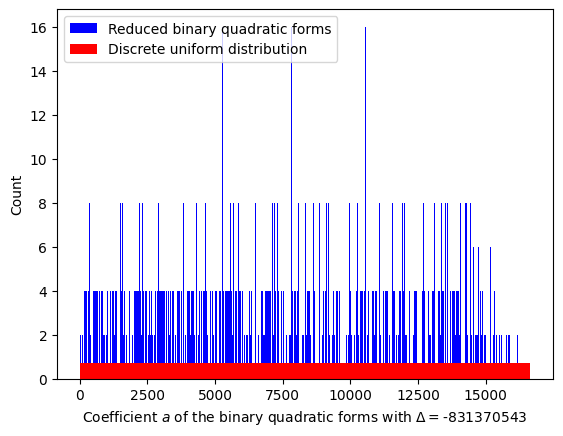

In [114]:
coefficientADensity = Counter(coefficientsA)
#print(coefficientADensity)
key = coefficientADensity.keys()
values = coefficientADensity.values()
print("Number of reduced forms:",sum(values))
print("Character:",(sum(values)*3.1415926)/math.sqrt(-discriminant))

## Distribution of the coefficient "A" in the studied class group of imaginary quadratic field
allCoefficientADensity = Counter(allCoefficientsA)
allKey = allCoefficientADensity.keys()
allValues = allCoefficientADensity.values()

#print(allCoefficientADensity)
## Uniform distribution 
uniformX = [i for i in range(rangeA)]
uniformY = [sum(values)/rangeA for i in range(rangeA)]

#plt.bar(allKey, allValues, width=4, color='red', label='All binary quadratic forms')
plt.bar(key, values, width=4, color='blue', label='Reduced binary quadratic forms')
plt.bar(uniformX, uniformY, width=4, color='red', label='Discrete uniform distribution')
plt.xlabel('Coefficient $a$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
#plt.yscale('log')
#plt.title("The distribution of coefficient $a$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientAdensity.pdf")
plt.show()

In [112]:
## Chi-squared test for the coefficient A
numOfIntervals = math.ceil(math.log(rangeA))
lenOfIntervals = rangeA/numOfIntervals
expectedInterval = [uniformY[0]*lenOfIntervals for i in range(numOfIntervals)]
observedInterval = [0]*numOfIntervals
print(lenOfIntervals)
for i in range(numOfIntervals):
    counter = 0
    for k in key:
        if i*lenOfIntervals<k and k<(i+1)*lenOfIntervals:
            counter+=coefficientADensity[k] 
    observedInterval[i] = counter
print("Expected discrete probability distribution for coefficient A", expectedInterval)
print("Observed discrete probability distribution for coefficient A", observedInterval)
chisquare(f_obs=observedInterval, f_exp=expectedInterval)

1665.0
Expected discrete probability distribution for coefficient A [1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9]
Observed discrete probability distribution for coefficient A [1345, 1350, 1288, 1330, 1274, 1372, 1324, 1322, 1174, 250]


Power_divergenceResult(statistic=861.7348906808545, pvalue=1.0832748286251192e-179)

KeyboardInterrupt: 

/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


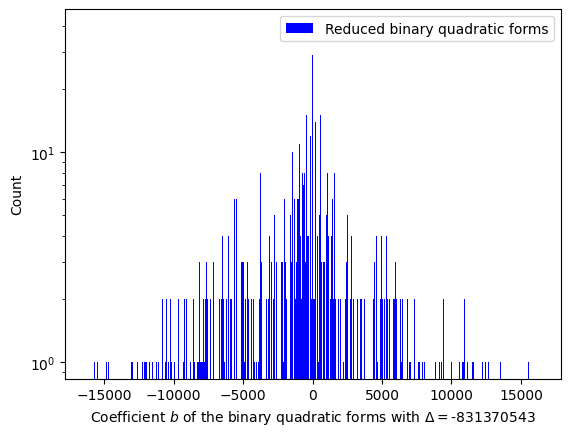

In [113]:
coefficientBDensity = Counter(coefficientsB)
key = coefficientBDensity.keys()
values = coefficientBDensity.values()

allCoefficientBDensity = Counter(allCoefficientsB)
allKey = allCoefficientBDensity.keys()
allValues = allCoefficientBDensity.values()

#plt.bar(allKey, allValues, width=2, color='red', label='All binary quadratic forms')
plt.bar(key, values, width=4, color='blue', label='Reduced binary quadratic forms')
plt.xlabel('Coefficient $b$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
plt.yscale('log')
#plt.title("The distribution of coefficient $b$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientBdensity.pdf")
plt.show()

In [109]:
## Chi-squared test for the coefficient B
numOfIntervals = math.ceil(math.log(rangeA))
lenOfIntervals = rangeA/numOfIntervals
observedInterval = [0]*numOfIntervals
for i in range(numOfIntervals):
    counter = 0
    print(i*lenOfIntervals)
    for k in key:
        if i*lenOfIntervals<=k and k<(i+1)*lenOfIntervals:
            counter+=coefficientBDensity[k] 
    observedInterval[i] = counter

expectedInterval = [sum(observedInterval)/numOfIntervals for i in range(numOfIntervals)]
print("Expected discrete probability distribution for coefficient B", expectedInterval)
print("Observed discrete probability distribution for coefficient B", observedInterval)
chisquare(f_obs=observedInterval, f_exp=expectedInterval)

0.0
1665.0
3330.0
4995.0
6660.0
8325.0
9990.0
11655.0
13320.0
14985.0
Expected discrete probability distribution for coefficient B [601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5]
Observed discrete probability distribution for coefficient B [2148, 1100, 816, 655, 452, 343, 252, 144, 72, 33]


Power_divergenceResult(statistic=6173.280964256027, pvalue=0.0)

In [ ]:
coefficientCDensity = Counter(coefficientsC)
key = coefficientCDensity.keys()
values = coefficientCDensity.values()


#allCoefficientCDensity = Counter(allCoefficientsC)
#allKey = allCoefficientCDensity.keys()
#allValues = allCoefficientCDensity.values()

#plt.bar(allKey, allValues, width=2, color='red', label='All binary quadratic forms')
#plt.hist(key)
plt.bar(key, values, width=2, color='blue', label='Reduced binary quadratic forms')
plt.xlabel('Coefficient $c$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
#plt.yscale('log')
plt.xscale('log')
#plt.title("The distribution of coefficient $b$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientCdensity.pdf")
plt.show()

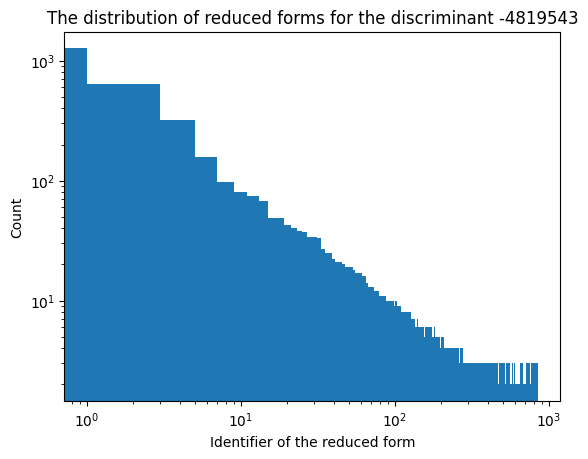

In [12]:
seenReducedFormDensity = Counter(seenReducedForms)
key = seenReducedFormDensity.keys()
values = seenReducedFormDensity.values()

plt.bar(key, values, width=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Identifier of the reduced form')
plt.ylabel("Count")
plt.title("The distribution of reduced forms for the discriminant "+str(discriminant))
plt.savefig("./Figures/reducedFormDist.pdf")
plt.show()

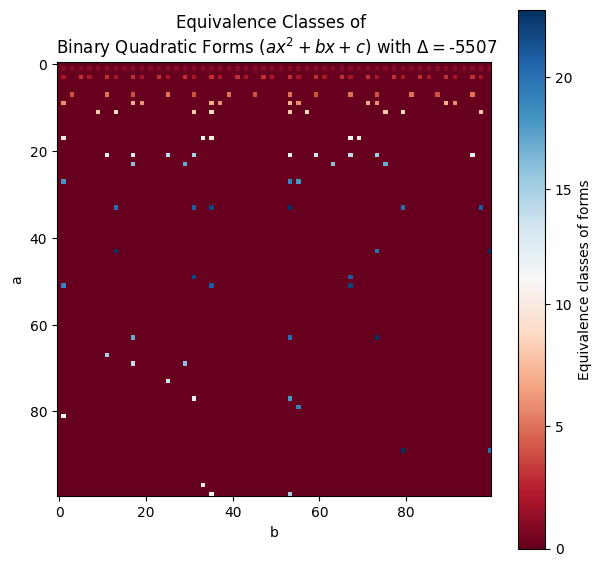

In [5]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)
ax.set_title("Equivalence Classes of \n Binary Quadratic Forms $(ax^2+bx+c)$ with $\Delta=$"+str(discriminant))
plt.xlabel("b")
plt.ylabel("a")
norm = mcolors.TwoSlopeNorm(vmin=classGroups.min(), vmax = classGroups.max(), vcenter=classGroups.max()//2)
plt.imshow(classGroups,cmap=plt.cm.RdBu, norm=norm)
ax.set_aspect('equal')
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('Equivalence classes of forms')
plt.savefig("./Figures/existingFormsWithDiscriminant.pdf")

[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800.]
[Text(-200.0, 0, '−200'), Text(0.0, 0, '0'), Text(200.0, 0, '200'), Text(400.0, 0, '400'), Text(600.0, 0, '600'), Text(800.0, 0, '800'), Text(1000.0, 0, '1000'), Text(1200.0, 0, '1200'), Text(1400.0, 0, '1400'), Text(1600.0, 0, '1600'), Text(1800.0, 0, '1800')]


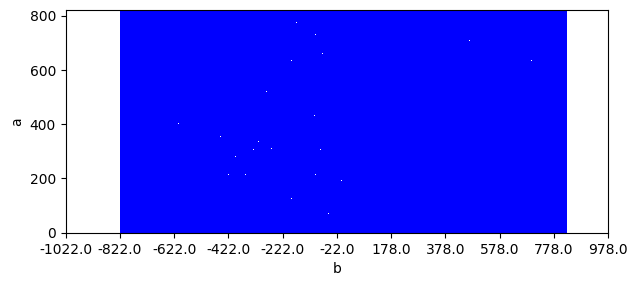

In [70]:
#classGroups = classGroups.transpose()
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
#ax.set_title("Equivalence Classes of \n Binary Quadratic Forms $(ax^2+bx+c)$ with $\Delta=$"+str(discriminant))
plt.xlabel("b")
plt.ylabel("a")
cmapmine = ListedColormap(['b', 'w'], N=2)
#norm = mcolors.TwoSlopeNorm(vmin=classGroups.min(), vmax = classGroups.max(), vcenter=classGroups.min())
plt.imshow(classGroups,cmap=cmapmine, vmin=0, vmax=1, interpolation='none')
#ax.set_aspect('equal')
plt.gca().invert_yaxis()
#cbar = plt.colorbar(orientation='vertical')
#cbar.set_label('Equivalence classes of forms')
# ytikcs
locs,labels = plt.xticks()
print(locs)
print(labels)
plt.xticks(locs, map(lambda x: x-classGroups.shape[0], locs))
plt.savefig("./Figures/coefficientAandBheatmap.pdf")

In [41]:
print(classGroups.shape[0])
print(classGroups.min(),classGroups.max())

20
0.0 1.0


In [13]:
## Orbit of a quadratic binary form by multiplying with a SL(Z,2) matrix

In [14]:
## Visualizing the class group operation via visualizing repeated squaring

In [11]:
def modular_sqrt(a, p):

    def legendre_symbol(a, p):
        """ Compute the Legendre symbol a|p using
            Euler's criterion. p is a prime, a is
            relatively prime to p (if p divides
            a, then a|p = 0)
            Returns 1 if a has a square root modulo
            p, -1 otherwise.
        """
        ls = pow(a, (p - 1) // 2, p)
        return -1 if ls == p - 1 else ls

    """ Find a quadratic residue (mod p) of 'a'. p
        must be an odd prime.
        Solve the congruence of the form:
            x^2 = a (mod p)
        And returns x. Note that p - x is also a root.
        0 is returned is no square root exists for
        these a and p.
        The Tonelli-Shanks algorithm is used (except
        for some simple cases in which the solution
        is known from an identity). This algorithm
        runs in polynomial time (unless the
        generalized Riemann hypothesis is false).
    """
    # Simple cases
    #
    if legendre_symbol(a, p) != 1:
        return 0
    elif a == 0:
        return 0
    elif p == 2:
        return p
    elif p % 4 == 3:
        return pow(a, (p + 1) // 4, p)

    # Partition p-1 to s * 2^e for an odd s (i.e.
    # reduce all the powers of 2 from p-1)
    #
    s = p - 1
    e = 0
    while s % 2 == 0:
        s //= 2
        e += 1

    # Find some 'n' with a legendre symbol n|p = -1.
    # Shouldn't take long.
    #
    n = 2
    while legendre_symbol(n, p) != -1:
        n += 1

    # Here be dragons!
    # Read the paper "Square roots from 1; 24, 51,
    # 10 to Dan Shanks" by Ezra Brown for more
    # information
    #

    # x is a guess of the square root that gets better
    # with each iteration.
    # b is the "fudge factor" - by how much we're off
    # with the guess. The invariant x^2 = ab (mod p)
    # is maintained throughout the loop.
    # g is used for successive powers of n to update
    # both a and b
    # r is the exponent - decreases with each update
    #
    x = pow(a, (s + 1) // 2, p)
    b = pow(a, s, p)
    g = pow(n, s, p)
    r = e

    while True:
        t = b
        m = 0
        for m in range(r):
            if t == 1:
                break
            t = pow(t, 2, p)

        if m == 0:
            return x

        gs = pow(g, 2 ** (r - m - 1), p)
        g = (gs * gs) % p
        x = (x * gs) % p
        b = (b * g) % p
        r = m

In [43]:
# Utility function to do modular exponentiation. 
# It returns (x^y) % p.
def power(x, y, p) :
 
    res = 1 # Initialize result 
    x = x % p # Update x if it is more 
              # than or equal to p 
 
    while (y > 0): 
         
        # If y is odd, multiply x with result 
        if (y & 1):
            res = (res * x) % p 
 
        # y must be even now 
        y = y >> 1 # y = y/2 
        x = (x * x) % p 
 
    return res 
 
# Returns true if square root of n under
# modulo p exists. Assumption: p is of the
# form 4*i + 3 where i >= 1 
def squareRoot(n, p): 
 
    if (p % 4 != 3) : 
        print( "Invalid Input" )
        return
 
 
    # Try "+(n^((p + 1)/4))" 
    n = n % p 
    x = power(n, (p + 1) // 4, p) 
    if ((x * x) % p == n): 
        return
 
    # Try "-(n ^ ((p + 1)/4))" 
    x = p - x 
    if ((x * x) % p == n): 
        return

In [153]:
## This algorithm was suggested by Benjamin Wesolowski and implemented by Giacomo Pope
## Room for improvement: only generates class group elements of the form (p,b,c) for some prime
## Hence, not a surjective mapping to the class group. 
def random_ClassGroupElement(discriminant,a): #a should be a random prime
    D_mod_a = discriminant % a
    b = modular_sqrt(discriminant, a)
    #print("first",discriminant,a,b,(b*b-discriminant) / (4*a))
    if b == 0:
        return (0,0)
    if b % 2 == 0:
        b = (a - b)
    ##if discriminant % 4 == 0:
    ##    b = crt([b, 2], [(a, 1), (2, 2)], 4*a)
    c = int((b*b-discriminant) / (4*a))
    #print("second",discriminant,a,b,c)
    if c == 0 or b*b-4*a*c!=discriminant: #((b*b-discriminant)%(4*a)) != 0 or
        return (0,0)
    sign = randint(0,1)
    if sign:
        return  (a, b)
    return  (a, -b)

In [202]:
howManyTimes = 1000
bitLengths = [i for i in range(16,108,4)]
outcnt = 0
measuredTimes = []
measuredAttempts = []


for bitLength in bitLengths:   
    myDiscriminant = 0
    while -myDiscriminant%4 != 1: ## we can only use discriminants%4 = 1
        myDiscriminant = random_prime(bitLength)
    #print(math.log(myDiscriminant,2),-myDiscriminant)
    # Start timer
    start_time = time.time()
    
    cnt = 0
    attempts = 0
    # The hashing algorithm by Benjamin&Giacomo
    while cnt!=howManyTimes:
        attempts+=1
        p = random_prime(bitLength//2-2)
        (a,b) = random_ClassGroupElement(-myDiscriminant,p)
        if p!=a:
            continue
        #print(attempts, -myDiscriminant,a,b)
        if b!=0:
            cnt+=1
            #print(cnt,a%4,BQuadForm(a,b,disc=-myDiscriminant))

    # End timer
    end_time = time.time()
    outcnt+=1
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    measuredTimes.append(elapsed_time/howManyTimes)
    measuredAttempts.append(attempts)
    print("Elapsed time for sampling 1 random class group element with a "+str(bitLength)+"-bit discriminant: ", elapsed_time/howManyTimes, " made with "+str(attempts)+" attempts.") 


Elapsed time for sampling 1 random class group element with a 16-bit discriminant:  0.00031149530410766604  made with 2385 attempts.
Elapsed time for sampling 1 random class group element with a 20-bit discriminant:  0.00030526113510131835  made with 2045 attempts.
Elapsed time for sampling 1 random class group element with a 24-bit discriminant:  0.000360137939453125  made with 1870 attempts.
Elapsed time for sampling 1 random class group element with a 28-bit discriminant:  0.0004724421501159668  made with 2311 attempts.
Elapsed time for sampling 1 random class group element with a 32-bit discriminant:  0.0003983299732208252  made with 1976 attempts.
Elapsed time for sampling 1 random class group element with a 36-bit discriminant:  0.00048153209686279297  made with 2097 attempts.
Elapsed time for sampling 1 random class group element with a 40-bit discriminant:  0.0006194541454315186  made with 2031 attempts.
Elapsed time for sampling 1 random class group element with a 44-bit discr

In [176]:
test = BQuadForm(1, 31, 2308)
test.a = 1
test.b = 31
test.c = 2308
print(test)
test._BQuadForm__reduction()
print(test)
print(test.isReduced())

(1, 31, 2308) disc: -8271
(1, 1, 2068) disc: -8271
True


[ 16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84
  88  92  96 100 104] 23


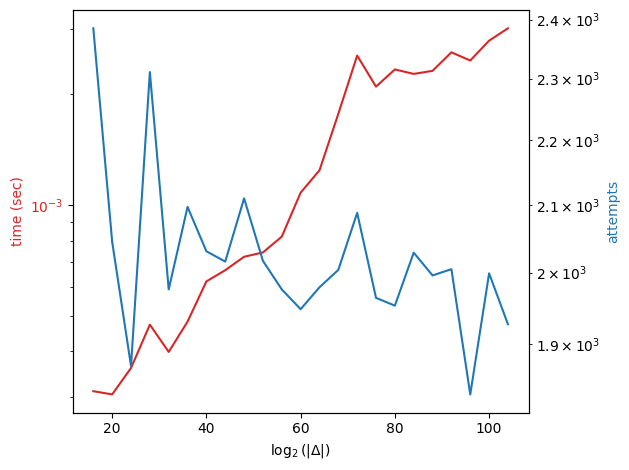

In [203]:
## Let us plot the number attempts on one of the y-axis, while on the other, we plot
## the number it took on average to hash using Wesolowski's hash to BQForm construction
# Create some mock data
t = np.array(bitLengths)
data1 = measuredTimes ##time to hash on average
data2 = measuredAttempts ##number of attempts
print(t,len(data1))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('$\log_2(|\Delta|)$')
ax1.set_ylabel('time (sec)', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('attempts', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./Figures/performanceWesolowskiTimevsAttempts.pdf")
plt.show()

In [231]:
## This hashing algorithm is inspired by the CSIDH construction
## See the original CSIDH paper here (page 13): https://eprint.iacr.org/2018/383.pdf
def random_ClassGroupElementCSIDH(discriminant, primeIdeals, seed):
    ## In our applications, the discriminant will always be a large odd prime
    ## We initialize the random form to be the identity element in the class group
    randomForm = BQuadForm(1,1, disc=discriminant)
    for i in range(len(primeIdeals)):
        if seed & (1 << i) != 0:
            randomForm = randomForm.__mul__(primeIdeals[i])
    return randomForm

In [ ]:
primes = []
with open('primes.json') as f:
   primes = json.load(f)

In [247]:
## Preprocessing step where we generate the random prime ideals that we will be using as generating set for the sampling of a random class group element.
bitLength = 2**64
myDiscriminant = -random_prime(bitLength)
print("My discriminant:", myDiscriminant)
primeIdeals = []
while len(primeIdeals)!=2*int(math.log(-myDiscriminant,2)):
    (a,b)=random_ClassGroupElement(myDiscriminant,random_prime(bitLength))
    if (a,b)!=(0,0):
        primeIdeals.append(BQuadForm(a,b, disc=myDiscriminant))
        print(len(primeIdeals),BQuadForm(a,b, disc=myDiscriminant))

My discriminant: -15024886940564752543
1 (569053279, -555687985, 6736485248) disc: -15024886940564752543
2 (224663776, -4069199, 16719321386) disc: -15024886940564752543
3 (1466310817, -26987295, 2561805976) disc: -15024886940564752543
4 (320789854, 132432689, 11722959104) disc: -15024886940564752543
5 (770464168, 6608273, 4875285326) disc: -15024886940564752543
6 (957249067, 922248357, 4146107194) disc: -15024886940564752543
7 (426615506, -210241729, 8830602916) disc: -15024886940564752543
8 (2006355812, 1599911471, 2191112308) disc: -15024886940564752543
9 (47096797, -14019823, 79756397744) disc: -15024886940564752543
10 (356828396, 134835401, 10539427141) disc: -15024886940564752543
11 (1601850116, 969227735, 2491539187) disc: -15024886940564752543
12 (1540709212, 305547505, 2453131016) disc: -15024886940564752543
13 (60259126, 26028397, 62337298163) disc: -15024886940564752543
14 (1547887292, -694897129, 2504667013) disc: -15024886940564752543
15 (1421849626, -324866441, 2660342006

In [248]:
howManyTimes = 100

# Start timer
start_time = time.time()
    
for i in range(howManyTimes):
    s = random.randint(0, (2**10)*bitLength - 1)
    a=random_ClassGroupElementCSIDH(myDiscriminant,primeIdeals,s)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for sampling 1 random class group element with a "+str(math.log(bitLength,2))+"-bit discriminant: ", elapsed_time/howManyTimes) 

Elapsed time for sampling 1 random class group element with a 64.0-bit discriminant:  0.0009714698791503906


In [249]:
## Benjamin-Giacomo hash
# Elapsed time for sampling 1 random class group element with a 32.0-bit discriminant:  0.0010533094406127929
# Elapsed time for sampling 1 random class group element with a 64.0-bit discriminant:  0.008581995964050293
## CSIDH hash (Kutas Peti construction)
# Elapsed time for sampling 1 random class group element with a 32.0-bit discriminant:  0.0003685798645019531
# Elapsed time for sampling 1 random class group element with a 64.0-bit discriminant:  0.0009714698791503906

coefficient of determination: 0.9178507707430261
intercept: -0.0006224632642485887
slope: [3.38866347e-05]
predicted response:
[[-8.02771086e-05]
 [ 5.52694303e-05]
 [ 1.90815969e-04]
 [ 3.26362508e-04]
 [ 4.61909047e-04]
 [ 5.97455586e-04]
 [ 7.33002125e-04]
 [ 8.68548664e-04]
 [ 1.00409520e-03]
 [ 1.13964174e-03]
 [ 1.27518828e-03]
 [ 1.41073482e-03]
 [ 1.54628136e-03]
 [ 1.68182790e-03]
 [ 1.81737444e-03]
 [ 1.95292097e-03]
 [ 2.08846751e-03]
 [ 2.22401405e-03]
 [ 2.35956059e-03]
 [ 2.49510713e-03]
 [ 2.63065367e-03]
 [ 2.76620021e-03]
 [ 2.90174675e-03]]
predicted response:
[[0.00371503]
 [0.00805252]
 [0.01239   ]
 [0.01672749]
 [0.02106498]
 [0.02540247]
 [0.02973996]
 [0.03407745]
 [0.03841494]
 [0.04275243]
 [0.04708992]
 [0.05142741]
 [0.0557649 ]
 [0.06010239]
 [0.06443988]
 [0.06877736]
 [0.07311485]
 [0.07745234]
 [0.08178983]
 [0.08612732]
 [0.09046481]
 [0.0948023 ]
 [0.09913979]
 [0.10347728]
 [0.10781477]
 [0.11215226]
 [0.11648975]
 [0.12082724]
 [0.12516472]
 [0.12950

Text(0, 0.5, 'time (sec)')

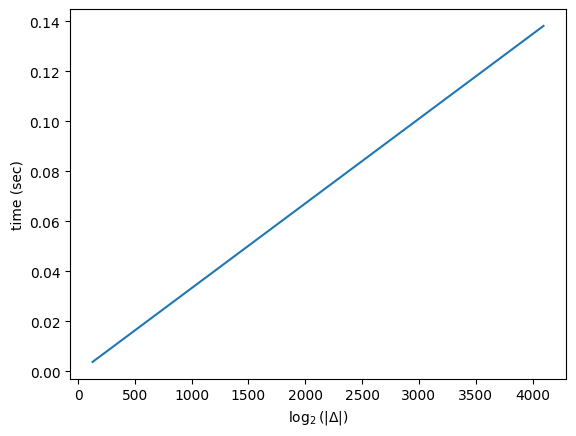

In [212]:
## Linear regression for the running time
## Useful link for Linear regression in Python
x = np.array(bitLengths).reshape((-1, 1))
y = np.array(measuredTimes)
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
y_pred = model.intercept_ + model.coef_ * x
print(f"predicted response:\n{y_pred}")
xNew = np.array([i for i in range(128,4097,128)]).reshape((-1, 1))
y_pred = model.intercept_ + model.coef_ * xNew
print(f"predicted response:\n{y_pred}")
plt.plot(xNew,y_pred)
plt.xlabel('$\log_2(|\Delta|)$')
plt.ylabel('time (sec)')